In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 16.5 MB/s 
     |████████████████████████████████| 7.6 MB 62.0 MB/s 
     |████████████████████████████████| 182 kB 54.5 MB/s 


In [2]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Model

In [3]:
!unzip dataset_all_genres.csv.zip

Archive:  dataset_all_genres.csv.zip
  inflating: dataset_all_genres.csv  


In [4]:
df = pd.read_csv('dataset_all_genres.csv')
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [5]:
df_sampled = df.groupby('primary_genre').sample(n=1750, random_state=200)

In [6]:
model_name = "distilgpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [7]:
class GPT2Classifier(nn.Module):
  def __init__(self, embedding_size, num_classes,max_seq_len, gpt_model_name):
    super(GPT2Classifier,self).__init__()
    self.gpt2 = GPT2Model.from_pretrained(gpt_model_name)
    # self.classifier_head = nn.Linear(embedding_size*max_seq_len, num_classes)    
    self.classifier_head = nn.Sequential(
                                nn.Linear(embedding_size*max_seq_len, 768),
                                nn.ReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(768, num_classes)
                              )

      
  def forward(self, input_id, mask):
    gpt_out, _ = self.gpt2(input_ids=input_id, attention_mask=mask, return_dict=False)
    batch_size = gpt_out.shape[0]
    linear_output = self.classifier_head(gpt_out.view(batch_size,-1))
    return linear_output

In [8]:
df_sampled['primary_genre'].value_counts()

Blues      1750
Country    1750
EDM        1750
Hip Hop    1750
Indie      1750
Pop        1750
R&B        1750
Rock       1750
Name: primary_genre, dtype: int64

In [9]:
"""
Prepare the dataset to finetune a transformer model
""" 
genre_labels = {'Blues': 0, 'Country': 1, 'EDM': 2, 'Hip Hop': 3, 'Indie': 4, 'Pop': 5, 'R&B': 6, 'Rock': 7}

class SongGenreClassificationDataset(Dataset):
    
    def __init__(self, texts, genres, max_length=128):
        if 'secondary_genre' in genres.columns:
          self.primary_labels = [genre_labels[genre] for genre in genres['primary_genre']]
          self.secondary_labels = [genre_labels[genre] if pd.notna(genre) else -1 for genre in genres['secondary_genre']]
        else:
          self.primary_labels = [genre_labels[genre] for genre in genres]
          self.secondary_labels = [-1 for genre in genres]
          # Tokenize
        self.tokenizer = tokenizer
        self.lyrics = []

        for text in texts:
          text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
          self.lyrics.append(self.tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt"))      

    def __len__(self):
        return len(self.primary_labels)

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.lyrics[idx]
        if len(self.secondary_labels) > 0:
          primary = self.primary_labels[idx]
          secondary = self.secondary_labels[idx]
          if secondary == -1:
            secondary = primary
          y = (primary, secondary)
        else:
          y = self.primary_labels[idx]
        return (x, y)

    

In [10]:
from torch.optim import Adam
from tqdm import tqdm

x_train, x_test, y_train, y_test = train_test_split(df_sampled['lyrics'], df_sampled[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state = 200)

def train_multiple_correct_labels(model, train_data, train_labels, val_data, val_labels, learning_rate, epochs, batch_size=2, max_seq_length=128):
    train, val = SongGenreClassificationDataset(train_data, train_labels,
                                                max_length=max_seq_length), SongGenreClassificationDataset(val_data, val_labels, max_length=max_seq_length)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

    # print(f"train dataloader: {len(train_dataloader)}")
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"training on {device}")
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    running_train_loss = []
    running_train_acc = []
    running_val_loss = []
    running_val_acc = []
    
    if use_cuda:
        print('using cuda')
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        print('starting')
        for i, (train_input, train_labels) in enumerate(tqdm(train_dataloader)):
            # train_labels = train_labels.to(device)
            if len(train_labels) > 1:
              train_label_primary = train_labels[0].to(device)
              train_label_secondary = train_labels[1].to(device)
            else:
              print('not val_labels')
              train_label_primary = train_labels.to(device)
            # train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)

            # batch_loss = loss_fn(output, train_label)
            batch_loss_primary = loss_fn(output, train_label_primary)
            

            if len(train_labels) > 1:
              batch_loss_secondary = loss_fn(output, train_label_secondary)
              

            total_loss_train += (max(batch_loss_primary.item(), batch_loss_secondary.item()))

            prediction_matches_primary = output.argmax(dim=1) == train_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == train_label_secondary 

            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_train += acc

            if batch_loss_primary.item() < batch_loss_secondary.item():
              batch_loss_secondary.backward()
            else:
              batch_loss_primary.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_labels in val_dataloader:

              if len(val_labels) > 1:
                val_label_primary = val_labels[0].to(device)
                val_label_secondary = val_labels[1].to(device)
              else:
                val_label_primary = val_labels.to(device)
                val_label = val_label.to(device)

              mask = val_input['attention_mask'].to(device)
              input_id = val_input['input_ids'].squeeze(1).to(device)
              
              output = model(input_id, mask)
              
              batch_loss_primary = loss_fn(output, val_label_primary)
            
              if len(val_labels) > 1:
                batch_loss_secondary = loss_fn(output, val_label_secondary)

              total_loss_val += (max(batch_loss_primary.item(), batch_loss_secondary.item()))
              # total_loss_val += batch_loss.item()

              prediction_matches_primary = output.argmax(dim=1) == val_label_primary 
              prediction_matches_secondary = output.argmax(dim=1) == val_label_secondary 
              
              acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
              # acc = (output.argmax(dim=1)==val_label).sum().item()
              total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_dataloader): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

            running_train_loss.append(total_loss_train/len(train_dataloader))
            running_train_acc.append(total_acc_train / len(train_data))
            running_val_loss.append(total_loss_val / len(val_dataloader))
            running_val_acc.append(total_acc_val / len(val_data))
            
    return model, running_train_loss, running_train_acc, running_val_loss, running_val_acc

Train the model:

In [ ]:
EPOCHS = 3
model_multiple_correct_labels = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels, tr_loss, tr_acc, v_loss, v_acc = train_multiple_correct_labels(model_multiple_correct_labels, x_train, y_train, x_val, y_val, LR, EPOCHS)


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4900/4900 [07:27<00:00, 10.95it/s]


Epochs: 1 | Train Loss:  0.772             | Train Accuracy:  0.521             | Val Loss:  0.682             | Val Accuracy:  0.595
starting


100%|██████████| 4900/4900 [07:28<00:00, 10.94it/s]


Epochs: 2 | Train Loss:  0.503             | Train Accuracy:  0.776             | Val Loss:  0.691             | Val Accuracy:  0.612
starting


100%|██████████| 4900/4900 [07:28<00:00, 10.93it/s]


Epochs: 3 | Train Loss:  0.356             | Train Accuracy:  0.957             | Val Loss:  0.749             | Val Accuracy:  0.606


In [11]:
def evaluate_multiple_correct(model, test_data, test_labels, max_seq_length=128):

    test = SongGenreClassificationDataset(test_data, test_labels, max_length=max_seq_length)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_labels in test_dataloader:

            if len(test_labels) > 1:
                test_label_primary = test_labels[0].to(device)
                test_label_secondary = test_labels[1].to(device)
                
            else:
                test_label_primary = test_labels.to(device)

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            prediction_matches_primary = output.argmax(dim=1) == test_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == test_label_secondary 
              
            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_test += acc
            
            # add original labels
            test_label_primary = test_label_primary.cpu().numpy().flatten().tolist()
            test_label_secondary = test_label_secondary.cpu().numpy().flatten().tolist()
            output_preds = output.argmax(dim=1).cpu().numpy().flatten().tolist()

            for i in range(len(test_label_primary)):
                if test_label_primary[i] == output_preds[i]:
                    true_labels.append(test_label_primary[i])
                elif test_label_secondary[i] == output_preds[i]:
                    true_labels.append(test_label_secondary[i])
                else:
                    true_labels.append(test_label_primary[i])

            # true_labels += test_label_secondary.cpu().numpy().flatten().tolist()
            # get predictions to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    


Test Accuracy:  0.616


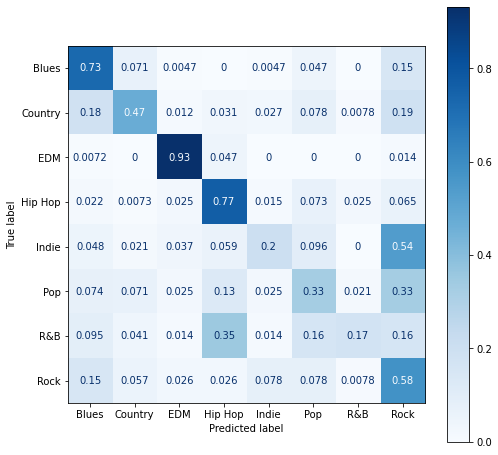

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

### Try without pop genre

In [ ]:
# remove the pop genre to see if performance is better
df_no_pop = df_sampled[df_sampled['primary_genre']!= 'Pop']

x_train_no_pop, x_test_no_pop, y_train_no_pop, y_test_no_pop = train_test_split(df_no_pop['lyrics'], df_no_pop[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_pop, x_test_no_pop, y_val_no_pop, y_test_no_pop = train_test_split(x_test_no_pop, y_test_no_pop, test_size=0.5, random_state = 200)

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_pop = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_pop, tr_loss_no_pop, tr_acc_no_pop, v_loss_no_pop, v_acc_no_pop = train_multiple_correct_labels(
    model_multiple_correct_labels_no_pop, x_train_no_pop, y_train_no_pop, x_val_no_pop, y_val_no_pop, LR, EPOCHS)


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4288/4288 [06:31<00:00, 10.96it/s]


Epochs: 1 | Train Loss:  0.741             | Train Accuracy:  0.555             | Val Loss:  0.679             | Val Accuracy:  0.594
starting


100%|██████████| 4288/4288 [06:30<00:00, 10.99it/s]


Epochs: 2 | Train Loss:  0.459             | Train Accuracy:  0.811             | Val Loss:  0.727             | Val Accuracy:  0.599
starting


100%|██████████| 4288/4288 [06:29<00:00, 11.00it/s]


Epochs: 3 | Train Loss:  0.338             | Train Accuracy:  0.958             | Val Loss:  0.693             | Val Accuracy:  0.653


Test Accuracy:  0.643


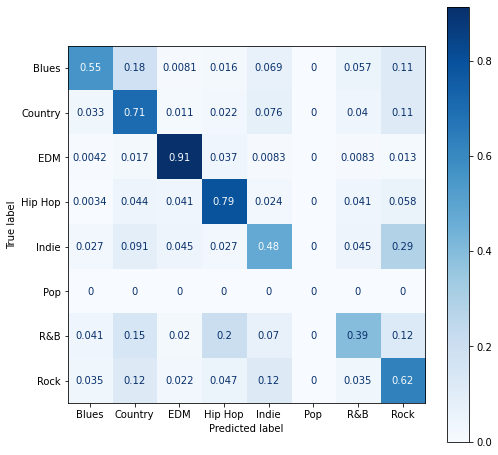

In [ ]:
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_pop, x_val_no_pop, y_val_no_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

### Try without indie genre

In [ ]:
# remove the indie genre to see if performance is better
df_no_indie = df_sampled[df_sampled['primary_genre']!= 'Indie']

x_train_no_indie, x_test_no_indie, y_train_no_indie, y_test_no_indie = train_test_split(df_no_indie['lyrics'], df_no_indie[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_indie, x_test_no_indie, y_val_no_indie, y_test_no_indie = train_test_split(x_test_no_indie, y_test_no_indie, test_size=0.5, random_state = 200)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4288/4288 [06:29<00:00, 11.00it/s]


Epochs: 1 | Train Loss:  0.727             | Train Accuracy:  0.555             | Val Loss:  0.652             | Val Accuracy:  0.634
starting


100%|██████████| 4288/4288 [06:30<00:00, 10.98it/s]


Epochs: 2 | Train Loss:  0.459             | Train Accuracy:  0.793             | Val Loss:  0.685             | Val Accuracy:  0.621
starting


100%|██████████| 4288/4288 [06:31<00:00, 10.95it/s]


Epochs: 3 | Train Loss:  0.322             | Train Accuracy:  0.960             | Val Loss:  0.677             | Val Accuracy:  0.647
Test Accuracy:  0.641


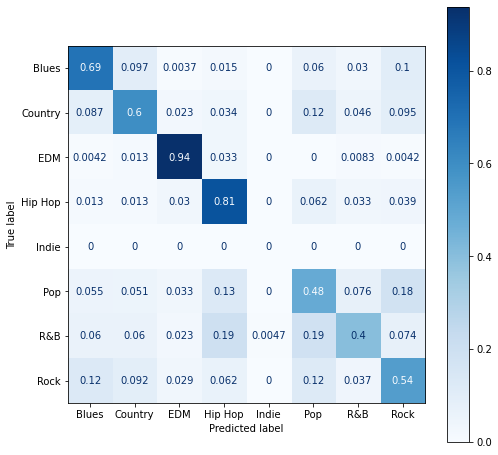

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_indie = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_indie, tr_loss_no_indie, tr_acc_no_indie, v_loss_no_indie, v_acc_no_indie = train_multiple_correct_labels(
    model_multiple_correct_labels_no_indie, x_train_no_indie, y_train_no_indie, x_val_no_indie, y_val_no_indie, LR, EPOCHS)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_indie, x_val_no_indie, y_val_no_indie)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


In [ ]:
torch.save(trained_model_correct_labels_no_indie.state_dict(), "gpt2-text-classifier-model-no-indie.pt")

In [ ]:
!zip gpt2-text-classifier-model-no-indie.pt.zip gpt2-text-classifier-model-no-indie.pt 

  adding: gpt2-text-classifier-model-no-indie.pt (deflated 8%)


### Try without indie and pop genres

In [12]:
# remove the pop and indie genres to see if performance is better
df_no_indie_pop = df_sampled[~df_sampled['primary_genre'].isin(['Indie', 'Pop']) & ~df_sampled['secondary_genre'].isin(['Indie', 'Pop'])]

x_train_no_indie_pop, x_test_no_indie_pop, y_train_no_indie_pop, y_test_no_indie_pop = train_test_split(df_no_indie_pop['lyrics'], df_no_indie_pop[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_indie_pop, x_test_no_indie_pop, y_val_no_indie_pop, y_test_no_indie_pop = train_test_split(x_test_no_indie_pop, y_test_no_indie_pop, test_size=0.5, random_state = 200)

# x_train_no_indie, x_test_no_indie, y_train_no_indie, y_test_no_indie = train_test_split(df_no_indie['lyrics'], df_no_indie[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
# x_val_no_indie, x_test_no_indie, y_val_no_indie, y_test_no_indie = train_test_split(x_test_no_indie, y_test_no_indie, test_size=0.5, random_state = 200)

In [13]:
df_no_indie_pop['primary_genre'].value_counts()

Blues      1750
EDM        1750
Country    1638
Hip Hop    1636
Rock       1570
R&B        1421
Name: primary_genre, dtype: int64

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 3418/3418 [05:10<00:00, 11.00it/s]


Epochs: 1 | Train Loss:  0.595             | Train Accuracy:  0.613             | Val Loss:  0.499             | Val Accuracy:  0.698
starting


100%|██████████| 3418/3418 [05:10<00:00, 11.02it/s]


Epochs: 2 | Train Loss:  0.327             | Train Accuracy:  0.859             | Val Loss:  0.569             | Val Accuracy:  0.689
starting


100%|██████████| 3418/3418 [05:09<00:00, 11.03it/s]


Epochs: 3 | Train Loss:  0.229             | Train Accuracy:  0.970             | Val Loss:  0.500             | Val Accuracy:  0.728
Test Accuracy:  0.726


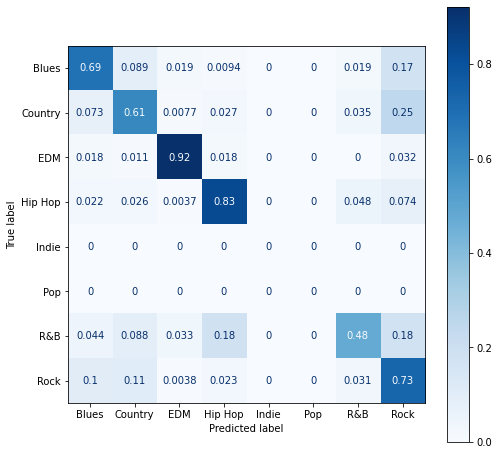

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_indie_pop = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_indie_pop, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model_multiple_correct_labels_no_indie_pop, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop, y_val_no_indie_pop, LR, EPOCHS)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_indie_pop, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


### Hyperparameter tuning

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 855/855 [02:14<00:00,  6.37it/s]


Epochs: 1 | Train Loss:  1.227             | Train Accuracy:  0.599             | Val Loss:  0.991             | Val Accuracy:  0.696
starting


100%|██████████| 855/855 [02:13<00:00,  6.40it/s]


Epochs: 2 | Train Loss:  0.711             | Train Accuracy:  0.834             | Val Loss:  1.002             | Val Accuracy:  0.699
starting


100%|██████████| 855/855 [02:13<00:00,  6.39it/s]


Epochs: 3 | Train Loss:  0.458             | Train Accuracy:  0.965             | Val Loss:  1.045             | Val Accuracy:  0.699
Test Accuracy:  0.696


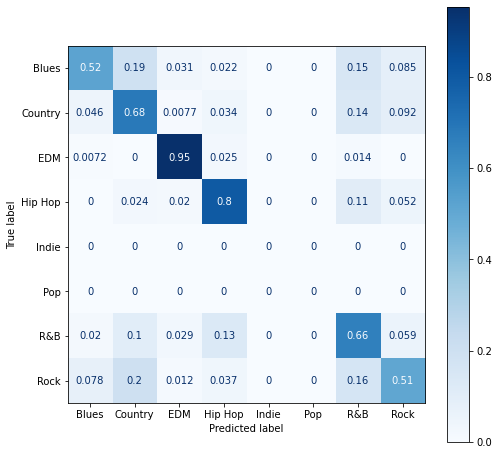

In [23]:
# batch size 8
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
BATCH_SIZE = 8

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie_pop = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [01:45<00:00,  4.07it/s]


Epochs: 1 | Train Loss:  1.257             | Train Accuracy:  0.579             | Val Loss:  1.033             | Val Accuracy:  0.668
starting


100%|██████████| 428/428 [01:44<00:00,  4.09it/s]


Epochs: 2 | Train Loss:  0.742             | Train Accuracy:  0.822             | Val Loss:  1.053             | Val Accuracy:  0.681
starting


100%|██████████| 428/428 [01:44<00:00,  4.09it/s]


Epochs: 3 | Train Loss:  0.468             | Train Accuracy:  0.956             | Val Loss:  0.994             | Val Accuracy:  0.721
Test Accuracy:  0.717


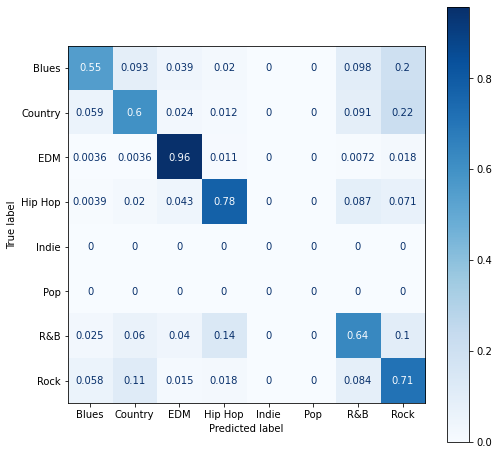

In [18]:
# batch size 16
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 214/214 [01:33<00:00,  2.28it/s]


Epochs: 1 | Train Loss:  1.299             | Train Accuracy:  0.560             | Val Loss:  1.094             | Val Accuracy:  0.657
starting


100%|██████████| 214/214 [01:33<00:00,  2.29it/s]


Epochs: 2 | Train Loss:  0.784             | Train Accuracy:  0.792             | Val Loss:  0.955             | Val Accuracy:  0.706
starting


100%|██████████| 214/214 [01:33<00:00,  2.29it/s]


Epochs: 3 | Train Loss:  0.472             | Train Accuracy:  0.946             | Val Loss:  1.019             | Val Accuracy:  0.701
Test Accuracy:  0.696


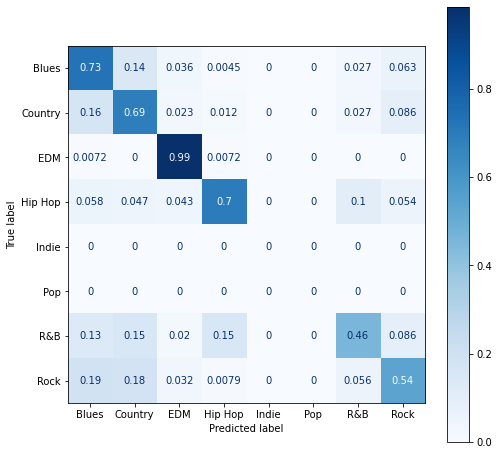

In [22]:
# batch size 32
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
BATCH_SIZE = 32

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 107/107 [01:26<00:00,  1.23it/s]


Epochs: 1 | Train Loss:  1.353             | Train Accuracy:  0.532             | Val Loss:  1.032             | Val Accuracy:  0.665
starting


100%|██████████| 107/107 [01:26<00:00,  1.23it/s]


Epochs: 2 | Train Loss:  0.832             | Train Accuracy:  0.764             | Val Loss:  0.948             | Val Accuracy:  0.713
starting


100%|██████████| 107/107 [01:26<00:00,  1.23it/s]


Epochs: 3 | Train Loss:  0.577             | Train Accuracy:  0.886             | Val Loss:  1.015             | Val Accuracy:  0.694
Test Accuracy:  0.701


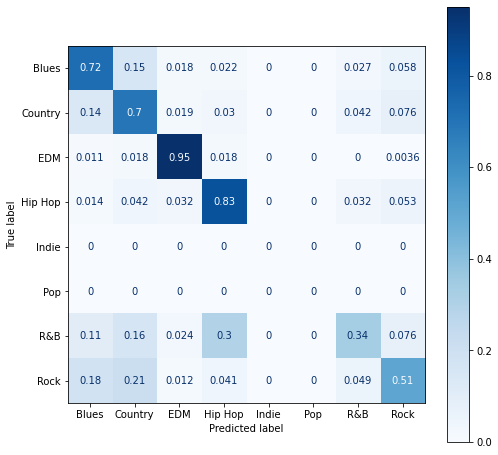

In [17]:
# batch size 64
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
BATCH_SIZE = 64

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 54/54 [01:22<00:00,  1.54s/it]


Epochs: 1 | Train Loss:  1.540             | Train Accuracy:  0.449             | Val Loss:  1.153             | Val Accuracy:  0.635
starting


100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epochs: 2 | Train Loss:  0.961             | Train Accuracy:  0.703             | Val Loss:  0.984             | Val Accuracy:  0.694
starting


100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epochs: 3 | Train Loss:  0.706             | Train Accuracy:  0.821             | Val Loss:  1.015             | Val Accuracy:  0.686
Test Accuracy:  0.687


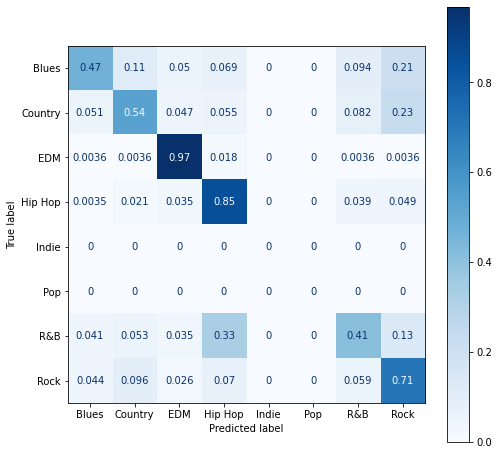

In [16]:
# batch size 128
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
BATCH_SIZE = 128

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [01:45<00:00,  4.07it/s]


Epochs: 1 | Train Loss:  1.206             | Train Accuracy:  0.626             | Val Loss:  0.975             | Val Accuracy:  0.695
starting


100%|██████████| 428/428 [01:44<00:00,  4.10it/s]


Epochs: 2 | Train Loss:  0.601             | Train Accuracy:  0.878             | Val Loss:  1.109             | Val Accuracy:  0.663
starting


100%|██████████| 428/428 [01:44<00:00,  4.09it/s]


Epochs: 3 | Train Loss:  0.425             | Train Accuracy:  0.977             | Val Loss:  0.953             | Val Accuracy:  0.732
Test Accuracy:  0.727


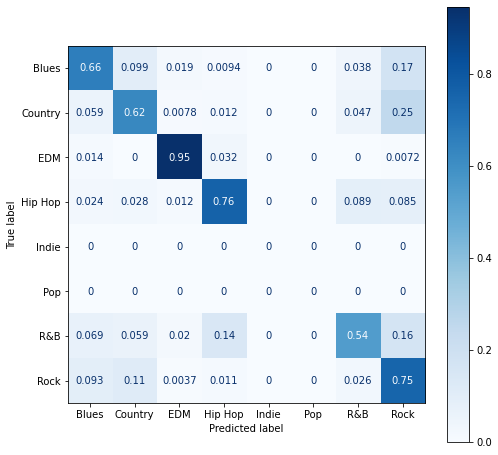

In [26]:
# LR 1e-4
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-4
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [01:41<00:00,  4.24it/s]


Epochs: 1 | Train Loss:  3.538             | Train Accuracy:  0.285             | Val Loss:  1.913             | Val Accuracy:  0.279
starting


100%|██████████| 428/428 [01:42<00:00,  4.17it/s]


Epochs: 2 | Train Loss:  1.504             | Train Accuracy:  0.398             | Val Loss:  1.269             | Val Accuracy:  0.516
starting


100%|██████████| 428/428 [01:42<00:00,  4.19it/s]


Epochs: 3 | Train Loss:  1.109             | Train Accuracy:  0.576             | Val Loss:  1.217             | Val Accuracy:  0.574
Test Accuracy:  0.574


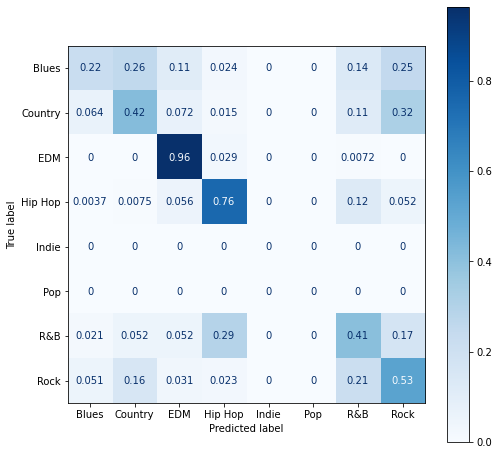

In [17]:
# LR 5e-4
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-3
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [03:21<00:00,  2.12it/s]


Epochs: 1 | Train Loss:  1.282             | Train Accuracy:  0.634             | Val Loss:  0.889             | Val Accuracy:  0.733
starting


100%|██████████| 428/428 [03:21<00:00,  2.12it/s]


Epochs: 2 | Train Loss:  0.617             | Train Accuracy:  0.870             | Val Loss:  0.919             | Val Accuracy:  0.747
starting


100%|██████████| 428/428 [03:20<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.438             | Train Accuracy:  0.969             | Val Loss:  0.913             | Val Accuracy:  0.760
Test Accuracy:  0.766


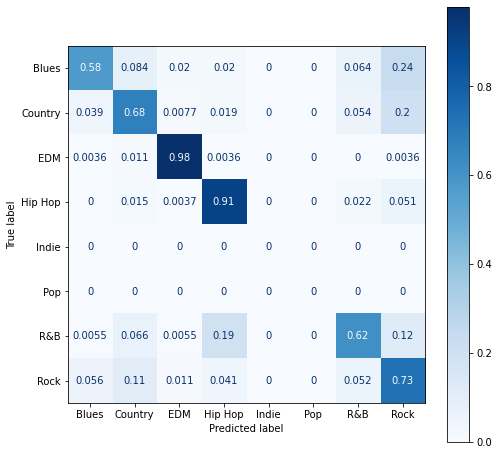

In [21]:
# LR 1e-4, max seq length 256
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=256, gpt_model_name=model_name)
LR = 1e-4
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE,
    max_seq_length = 256)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop, max_seq_length=256)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


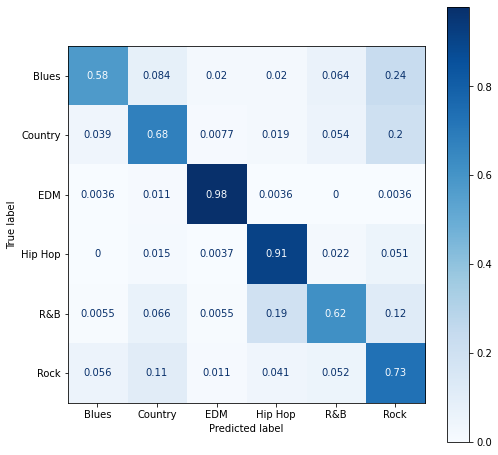

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=[0,1,2,3,6,7], normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blues', 'Country', 'EDM', 'Hip Hop', 'R&B', 'Rock'])
disp2.plot(ax=ax, cmap='Blues')

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [03:24<00:00,  2.09it/s]


Epochs: 1 | Train Loss:  1.229             | Train Accuracy:  0.634             | Val Loss:  0.913             | Val Accuracy:  0.714
starting


100%|██████████| 428/428 [03:28<00:00,  2.05it/s]


Epochs: 2 | Train Loss:  0.650             | Train Accuracy:  0.853             | Val Loss:  0.899             | Val Accuracy:  0.742
starting


100%|██████████| 428/428 [03:28<00:00,  2.05it/s]


Epochs: 3 | Train Loss:  0.436             | Train Accuracy:  0.961             | Val Loss:  0.842             | Val Accuracy:  0.767
Test Accuracy:  0.771


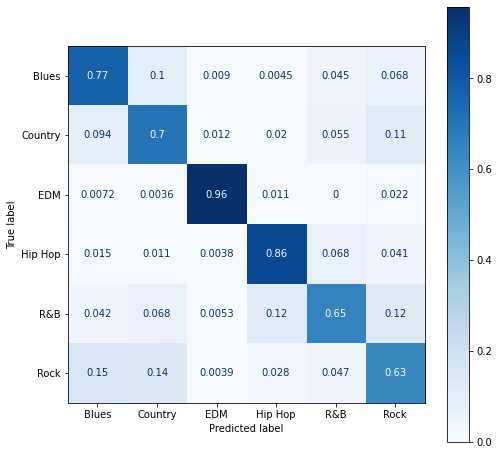

In [15]:
# LR 1e-4, max seq length 256
EPOCHS = 3
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=256, gpt_model_name=model_name)
LR = 1e-4
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE,
    max_seq_length = 256)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop, max_seq_length=256)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=[0,1,2,3,6,7], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blues', 'Country', 'EDM', 'Hip Hop', 'R&B', 'Rock'])
disp.plot(ax=ax, cmap='Blues')


Test Accuracy:  0.763


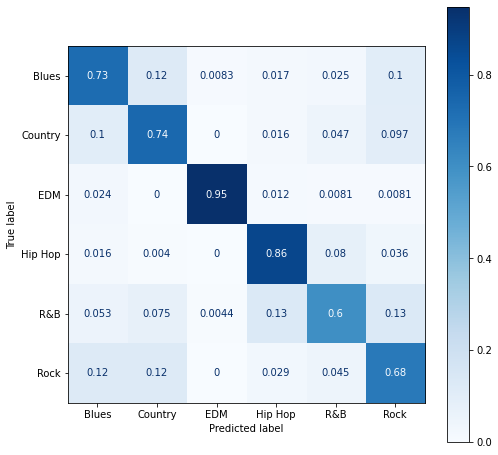

In [16]:
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_test_no_indie_pop, y_test_no_indie_pop, max_seq_length=256)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=[0,1,2,3,6,7], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blues', 'Country', 'EDM', 'Hip Hop', 'R&B', 'Rock'])
disp.plot(ax=ax, cmap='Blues')

In [70]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE1786 Project/Best model

Mounted at /content/drive
/content/drive/MyDrive/ECE1786 Project/Best model


In [71]:
torch.save(trained_model.state_dict(), "distilgpt2-best-model.pt")

In [18]:
x_test_no_indie_pop

82102    I believe the stars keep shining all throught ...
8310     Don't you ever be sad\nLean on me in times of ...
8871     (Gary Moore)\nSo many came before you,\nthe pr...
94182    I told you once, baby I told you once, but I k...
40601    [Intro]\nYuck Daddy! Yuck!\nYuck Daddy! Yuck!\...
                               ...                        
90403    Hello it's me\nYour son again\nI'll let myself...
30104    Fear of the dark\nTears me apart\nWon't leave ...
78227    [Intro]\n(I'mma make your legs shake, I'mma ma...
10638    You wonder why I'm grievin' and feelin' blue?\...
91225    the biggest fires are burning\nand i will try ...
Name: lyrics, Length: 1465, dtype: object

In [19]:
y_test_no_indie_pop

,primary_genre,secondary_genre
82102,Rock,NaN
8310,Blues,NaN
8871,Blues,Rock
94182,EDM,NaN
40601,Hip Hop,NaN
...,...,...
90403,Rock,NaN
30104,Rock,NaN
78227,R&B,Hip Hop
10638,Blues,NaN


In [55]:
zipped = zip(x_test_no_indie_pop,y_test_no_indie_pop['primary_genre'], y_test_no_indie_pop['secondary_genre'], true_labels, pred_labels)
df_test_results = pd.DataFrame(zipped, columns=["lyrics", "primary genre", "secondary genre","true label", "predicted"])


In [58]:
label_genre_map = {y: x for x, y in genre_labels.items()}
df_test_results['predicted genre'] = df_test_results['predicted'].map(label_genre_map)

In [31]:
pd.set_option('display.max_colwidth', None)

In [60]:
all_test_results = df_test_results[['lyrics','primary genre','secondary genre','predicted genre']]
all_test_results.head()

,lyrics,primary genre,secondary genre,predicted genre
0,"I believe the stars keep shining all throught the night.\nI believe if we just keep trying it will be alright.\nI believe that someday we're gonna find our way.\nAnd I believe in a beautiful day.\n\nI believe in lovers walking side by side.\nI believe that someday we'll be satisfied.\nI believe the angels listen god hears us pray.\nAnd I believe in a beautiful day.\n\nYeah I believe it's gonna work out ok.\nBut not for me, and not for you.\n\nI believe, I believe, I believe.\nI believe, I believe, I believe.\n\n( Guitar Solo )\n\nI believe there's an answer waiting when the day is done.\nI believe if you just keep searching you'll find someone.\nI believe that you and I just lost our way.\nAnd I believe in a beautiful day.\nI still believe in a beautiful day.\n\nBut not for me, and not for you.\nI know your tried, and I tried to.\nSometime all our dreams just don't come true.\nI believe, I believe, I believe.\nI believe, I believe, I believe.\nOh...Oh...Beautiful day\n\n",Rock,NaN,Rock
1,"Don't you ever be sad\nLean on me in times of bad\nWhen the day comes and you're in doubt\nIn a river of trouble about to drown\n\nHold On, hold on\nI'm coming, I'm coming\nHold On, hold on\nI'm coming, I'm coming\n\nI'm on my way your lover\nWhen you get cold\nI'll be your cover\nDon't have to worry\nBecause I'm here\nDon't need to suffer\nBecause I'm here\n\nHold On, hold on\nI'm coming, I'm coming\nHold On, hold on\nI'm coming, I'm coming\n\nReach out to me\nFor satisfaction\nCall my name\nQuick reaction\nHey hey hey\n\nDon't you ever be sad\nLean on me in times of bad\nWhen the day comes and you're in doubt\nIn a river of trouble about to drown\n\nDon't you ever be sad\nLean on me in times of bad\nHold On, hold on\nI'm coming, I'm coming\n",Blues,NaN,Blues
2,"(Gary Moore)\nSo many came before you,\nthe prisoners of fate.\nA history of bloodshed,\na legacy of hate.\nBut where will you be standing\nwhen the battles have been won?\nInside your lonely fortress\nthe battles just begun.\n\nAfter the war,\nwho will you be fighting for?\nAfter the war is over.\nAfter the fire\nis burning to its dying embers.\nAfter the war.\n\nA letter from the draft board\nput pain to all your dreams.\nYou're just another number\nin military schemes.\nThey marched you in a uniform\nyou wore against your will.\nWith lies of hope and glory,\nthey taught you how to kill.\n\nAfter the war,\nwho will you be fighting for?\nAfter the war is over.\nAfter the fire\nis burning to its dying embers.\n\nAfter the war,\nyou thought you'd be a hero,\nafter all that you survived.\nIf hell was meant for heroes,\nthen surely youâ€™ve arrived.\nAh.\n\nAfter the war,\nafter the war.\n\nAfter the war,\nwho will you be fighting for?\nAfter the war,\nwho will you be fighting for?\nAfter the fire\nis burning to its dying embers.\nAfter the war.\n",Blues,Rock,Blues
3,"I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go One, two, three, let's go But I know But I know I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go I told you once, baby I told you once, but I know You got to let it go One, two, three, let's go But I know But I know",EDM,NaN,Blues
4,"[Intro]\nYuck Daddy! Yuck!\nYuck Daddy! Yuck!\n\n[Verse 1: 2 Chainz]\nUh, cut the top off, call it Amber Rose\nJust bought a big body, time to paint the toes\nKnown to act a donkey on the camel-toe\nThen take the camel-toe and turn it into casserole\n2 Chainz talkin' on the FLX phone\nPoof! Just like that the whole check gone\nFormer Posturepedic I was slept on\nSo many chains on it look like my ne

In [62]:
all_test_results.to_csv('test_predictions.csv',index=False)

In [87]:
df_test_results.loc[(df_test_results['true label'] == df_test_results['predicted']) & (df_test_results['predicted genre']=='Blues'), ['lyrics','primary genre','secondary genre','predicted genre']].iloc[30:50]

,lyrics,primary genre,secondary genre,predicted genre
197,"Oh, black mama, what's the matter with you?\nSaid, if it ain't satisfactory, don't care what I do\nHey, mama, what's the matter with you?\nSaid, if it ain't satisfactory, baby, don't care what I do\nYou take a brownskin woman'll make a rabbit move to town\nSay, but a jet-black woman'll make a mule kick his stable down\nOh, a brownskin woman will make a rabbit move to town\nOh, but a real black woman'll make a mule kick his stable down\nSay, t'ain't no heaven, say, there ain't no burnin' hell\nSay, where I'm going when I die, can't nobody tell\nOh, there ain't no heaven, now, there ain't no burnin' hell\nOh, where I'm going when I die, can't nobody tell\nWell, my black mama's face shine like the sun\nOh, lipstick and powder sure won't help her none\nMy black mama's face shine like the sun\nOh, lipstick and powder, well, they sure won't help her none\nWell, you see my milk cow, tell her to hurry home\nI ain't had no milk cow since that cow been gone\nIf you see my milk cow, tell her to hurry home\nYeah, I ain't had no milk cow since that cow been gone\nWell, I'm going to the race track to see my pony run\nHe ain't the best in the world, but he's a runnin' son-of-a-gun\nI'm going to the race track to see my pony run\nHe ain't the best in the world, but he's a runnin' son-of-a-gun\nOh, Lord, have mercy on my wicked soul\nWouldn't mistreat you, baby, for my weight in gold\nOh, Lord, have mercy on my wicked soul\nWouldn't mistreat you, baby, for my weight in gold",Blues,NaN,Blues
203,"When I first met you, baby\nBaby, you were just sweet sixteen\nWhen I first met you, baby\nBaby, you were just sweet sixteen\nYou just left your home then, woman\nAh, the sweetest thing I'd ever seen\n\nBut you wouldn't do nothing, baby\nYou wouldn't do anything I asked to\nYou wouldn't do nothing for me, baby\nYou wouldn't do anything I asked to\nYou know you ran away from your home, baby\nAnd now you wanna run away from old ""B"" too\n\nMy brother's in Korea, baby\nMy sister's down in New Orleans\n\nYou can treat me mean, baby\nBut I'll keep on loving you just the same\nYou can treat me mean baby\nBut I'll keep on loving you just the same\nBut one of these days, baby\nYou're gonna give a lot of money\nTo hear someone call my name\n\nYes, sweet sixteen baby... sweet sixteen...\nYes, the sweetest thing baby\nThe sweetest thing I ever seen\nYou know I'm having so much trouble,\nwoman, so much trouble baby\nBaby I wonder\nYes I wonder\nBaby I wonder\nWhat in the world's gonna happen to me",Blues,NaN,Blues
213,"Well, if we live, we gotta grow old baby\nAnd I know just how you're going to be\nWell, if we live, we gotta grow old baby\nAnd I know just how you're going to be\nWell, your feet are already a little chilly baby\nAnd you're gettin' a little cold to me\n\nWell, you're gonna have a sweet and silly temper, baby\nBaby, and you're not gonna speak to me for days at a time\nOh, I know you're gonna have a sweet and silly temper, baby\nBaby, and you won't speak to me for days at a time\nOh baby, I know you're gettin' old\nAnd your little temper B. won't really mind\n\nOh, we'll be sittin' close together baby\nAnd our minds are really in tune\nOh, we'll be sittin' close together baby\nAnd our minds are really in tune\nWell, we'll start makin' love together, baby\nThinkin' about how we used to when we was really in bloom\n\nOh, I know you're gonna live like a king and queen\nBaby you won't mind a word I say\nI know you're gonna live like a king and queen\nBaby you won't mind a word I say\nYeah, we're gonna live and get old together, baby\nYeah, 'till we old and grey\n",Blues,NaN,Blues
214,"Jelly Jelly\nby Gregg Allman\nCopyright 1973 Allbro Music, Unichappell Music Inc. and Elijah Blue Music\n\nStormy stormy rain\nI'm as lonesome as a man can be\nOh, it's stormin', stormin' rain and\nI'm as lonesome as a man can be.\nWhoa, the way you've been treatin' me,\nI realize it's not the same.\n\nIt's a down-

In [65]:
df_test_results.loc[df_test_results['true label'] != df_test_results['predicted'], ['lyrics','primary genre','secondary genre','predicted genre']][100:200]

,lyrics,primary genre,secondary genre,predicted genre
468,"Lately I've found myself fallin'\nDeeper in love with you\nI'm not the kind of guy\nWho gets swept away\nSo here's what I'm gonna do\n\nI'm gonna give you this heart of mine\nBut that's where I draw the line\n\nI'm only gonna give you everything\nTake it a mile beyond the end, of the road\nI'm gonna love you one day past forever\nBut that's as far as it goes\n\nI know it may not sound like much\nBut baby make no mistake\nI'm gonna treat you with more tenderness\nThan any one woman can take\n\nI'm gonna make all your dreams come true\nBut after that baby I'm through\n\n\nI'm only gonna give you everything\nTake it a mile beyond the end, of the road\nI'm gonna love you one day past forever\nBut that's as far as it goes\n\nYou've got your limits, I've got mine\nI'm only gonna go the distance\nTime after time\n\n\nI'm only gonna give you everything\nTake it a mile beyond the end, of the road\nI'm gonna love you one day past forever\nBut that's as far as it goes\n\n\nBut that's as far as it goes\n",Country,NaN,Blues
477,"The block is hot, the cops is swarmin a neighborhood heavy\nWhile niggas off in the neighborhood sellin, with penitentiary chances\nThe dope roped up in the cup of their pants\nFiends flock like ??? come get this candy\nI got heroin in bundles, them Highland O's\nPlus a cooked slab, chopped up, dimes is swoll\nIf I spot the laws comin, hey its time to roll\nCandy Carter got a line of parole, Outta control\nThe first fell a Tuesday this month oh sweet thang\nPlus it's a sweet day, me next score for three days\nOne time they say what you mean, I gets the green\nBreak up the block like Maurice Green, ya feel me?\nIn my predicament I'm guilty until proven innocent\nHustle ridiculous, I'm tryin to get this dope continuos\nBall til I fall, one thing, I ain't tryin to fall\nWant everybody numb like ambasol\nBut he heard\n\n[Chorus 1]\nUh oh\nThere go them fuckin po-po's\nAnd if you know like I know\nYou better get off the corner\n\nI'm a young dog, wild and ecstatic, violent when passin\nhem gangstas doin time in a parishment, role models\nAnd keep ya cup, we drink whole bottles, and cuss at niggas\nLike fuck that nigga, I let my pump subtract niggas\nYou beef with me I guarantee your mams be missin\nWith a note behind demandin three chickens or she gets it\nDo not twist because lil man is trippin\nThey could have ya body in three different places\nAin't nothin gravy, but save it\nCause I'm a ride and hit the nigga street\nWeezy go to war like Sadaam and Clinton disagree\nWhile I'm shitty from the weed\nLike were them bustas be\nI promise ya never fuckin sleep, I clear the set\nCome outside late at night to your surprise I'm here with Tecks\nTwo shots knock off the niggas necks, it's so realistic\nSo I hope ya get it, or else them shots poke ya fetti\nBe on the block until them souljas hit it\nThat's when he heard....\n\n[Chorus 2]\nBlocka\nMe come to tear your block up\nIf you don't want no problems\nYou better get off the corner\n\nAll right, I cook it, cut it, ship and move it\nI make a livin in this crooked public distributin\nJust take a peek around, the hood is floodin, shit is boomin\nThe hottest D in town lookin for me hit me Tuesday, like after six\nSee I crack the bricks right down to Z's\nGot pounds of trees, my blocks blazin qp's to ki's\nGangin in the cheese, them bricks is comin\nNo droughts I don't sit on nothin\nI don't believe I'm frontin\nIf I give you a dime, I leave with somethin\nThe big dog, Nigga I got the city under siege\nAnd the law don't bother me, I give the pigs a couple of G's\nShit, I hustle strong to push this work through the streets\nI'm tryin to deal with every nigga, and sell the birds up cheap\nI'm greedy, if there's any money bein made from drugs I need it\nTwenty bricks two weeks completed, you can't beat it\nWhatever you want, holla at me when you need to get it\nDoes anybody else, I'll pay em a visit\nThat's when ya heard..

In [20]:

# LR 1e-4, max seq length 256
EPOCHS = 5
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=256, gpt_model_name=model_name)
LR = 1e-3
BATCH_SIZE = 16

trained_model, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop,  y_val_no_indie_pop, LR, EPOCHS, batch_size=BATCH_SIZE,
    max_seq_length = 256)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model, x_val_no_indie_pop, y_val_no_indie_pop, max_seq_len=256)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 428/428 [03:21<00:00,  2.12it/s]


Epochs: 1 | Train Loss:  4.733             | Train Accuracy:  0.400             | Val Loss:  1.191             | Val Accuracy:  0.549
starting


100%|██████████| 428/428 [03:19<00:00,  2.14it/s]


Epochs: 2 | Train Loss:  1.101             | Train Accuracy:  0.573             | Val Loss:  1.067             | Val Accuracy:  0.590
starting


100%|██████████| 428/428 [03:20<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.900             | Train Accuracy:  0.681             | Val Loss:  1.240             | Val Accuracy:  0.586
starting


100%|██████████| 428/428 [03:20<00:00,  2.14it/s]


Epochs: 4 | Train Loss:  0.757             | Train Accuracy:  0.772             | Val Loss:  1.123             | Val Accuracy:  0.666
starting


100%|██████████| 428/428 [03:20<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.629             | Train Accuracy:  0.846             | Val Loss:  1.230             | Val Accuracy:  0.696


TypeError: ignored

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 613/613 [04:49<00:00,  2.12it/s]


Epochs: 1 | Train Loss:  1.568             | Train Accuracy:  0.532             | Val Loss:  1.282             | Val Accuracy:  0.605
starting


100%|██████████| 613/613 [04:48<00:00,  2.12it/s]


Epochs: 2 | Train Loss:  0.960             | Train Accuracy:  0.769             | Val Loss:  1.310             | Val Accuracy:  0.631
starting


100%|██████████| 613/613 [04:48<00:00,  2.12it/s]


Epochs: 3 | Train Loss:  0.691             | Train Accuracy:  0.942             | Val Loss:  1.248             | Val Accuracy:  0.643
Test Accuracy:  0.646


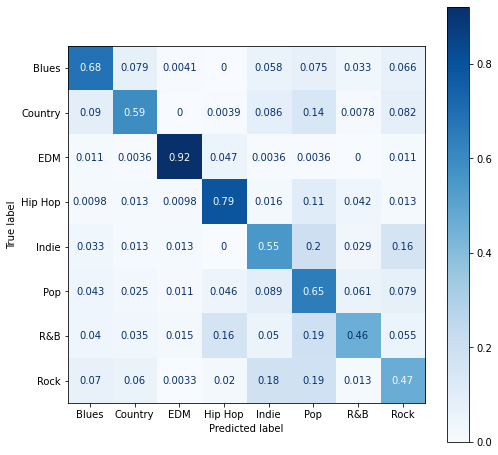

In [41]:
# LR 1e-4, max seq length 256
EPOCHS = 3
model_all_genres = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=256, gpt_model_name=model_name)
LR = 1e-4
BATCH_SIZE = 16

trained_model_all, tr_loss, tr_acc, v_loss, v_acc_no_indie = train_multiple_correct_labels(
    model_all_genres, x_train, y_train, x_val,  y_val, LR, EPOCHS, batch_size=BATCH_SIZE,
    max_seq_length = 256)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model_all, x_val, y_val, max_seq_length=256)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


In [18]:
import matplotlib.pyplot as plt

def show_plot(train_loss, val_loss, train_acc, val_acc):
  # if torch.cuda.is_available():
  #   train_acc = [acc.cpu() for acc in train_acc]
  #   val_acc = [acc.cpu() for acc in val_acc]
  
  x_range = range(1,len(train_loss)+1)
  plt.plot(x_range,train_loss)
  plt.plot(x_range,val_loss)
  plt.xlabel('Num epochs')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss')
  plt.show()

  plt.plot(x_range,train_acc)
  plt.plot(x_range,val_acc)
  plt.xlabel('Num epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy')
  plt.show()

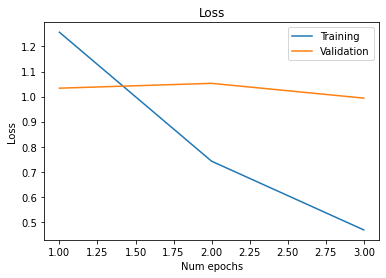

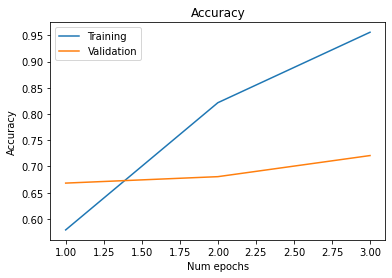

In [21]:
show_plot(tr_loss_no_indie_pop, v_loss_no_indie_pop, tr_acc_no_indie_pop, v_acc_no_indie)

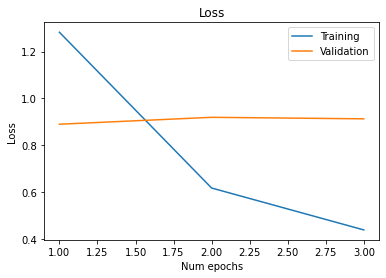

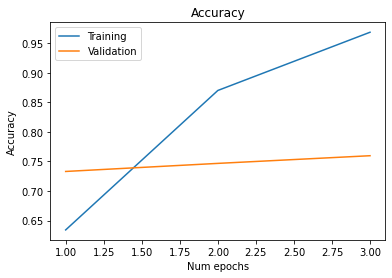

In [22]:
show_plot(tr_loss_no_indie_pop, v_loss_no_indie_pop, tr_acc_no_indie_pop, v_acc_no_indie)

In [ ]:
torch.save(model.state_dict(), "gpt2-text-classifier-model.pt")

Test Accuracy:  0.610


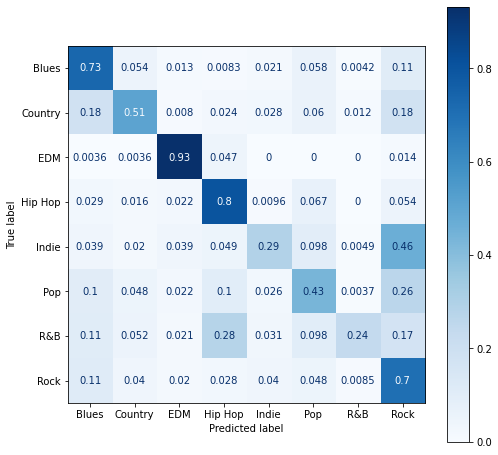

In [ ]:
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

Plot confusion matrix

Test Accuracy:  0.545


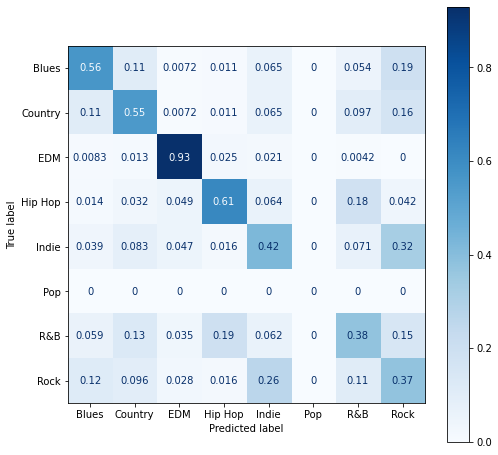

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, pred_labels = evaluate(model2, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

In [ ]:
# count parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model2)

+-----------------------------+------------+
|           Modules           | Parameters |
+-----------------------------+------------+
|       gpt2.wte.weight       |  38597376  |
|       gpt2.wpe.weight       |   786432   |
|     gpt2.h.0.ln_1.weight    |    768     |
|      gpt2.h.0.ln_1.bias     |    768     |
| gpt2.h.0.attn.c_attn.weight |  1769472   |
|  gpt2.h.0.attn.c_attn.bias  |    2304    |
| gpt2.h.0.attn.c_proj.weight |   589824   |
|  gpt2.h.0.attn.c_proj.bias  |    768     |
|     gpt2.h.0.ln_2.weight    |    768     |
|      gpt2.h.0.ln_2.bias     |    768     |
|   gpt2.h.0.mlp.c_fc.weight  |  2359296   |
|    gpt2.h.0.mlp.c_fc.bias   |    3072    |
|  gpt2.h.0.mlp.c_proj.weight |  2359296   |
|   gpt2.h.0.mlp.c_proj.bias  |    768     |
|     gpt2.h.1.ln_1.weight    |    768     |
|      gpt2.h.1.ln_1.bias     |    768     |
| gpt2.h.1.attn.c_attn.weight |  1769472   |
|  gpt2.h.1.attn.c_attn.bias  |    2304    |
| gpt2.h.1.attn.c_proj.weight |   589824   |
|  gpt2.h.

82699016